In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import datetime as dt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings("ignore")
sns.set(font_scale=1.4)
sns.set_style('darkgrid')

In [2]:
results = pd.read_csv('results.csv')

In [3]:
pd.set_option('display.max_columns', None)

First let us see if any of the maps are unbalanced in terms of teams gaining inhereit advantages being on the T side or the CT side. The motivation for this comes the community's 
understanding that maps like Nuke and Vertigo are unbalanced, so we will explore the statistics and see if we can find any trends.

In [4]:
results.head()

,date,team_1,team_2,_map,result_1,result_2,map_winner,starting_ct,ct_1,t_2,t_1,ct_2,event_id,match_id,rank_1,rank_2,map_wins_1,map_wins_2,match_winner
0,2020-03-18,Recon 5,TeamOne,Dust2,0,16,2,2,0,1,0,15,5151,2340454,62,63,0,2,2
1,2020-03-18,Recon 5,TeamOne,Inferno,13,16,2,2,8,6,5,10,5151,2340454,62,63,0,2,2
2,2020-03-18,New England Whalers,Station7,Inferno,12,16,2,1,9,6,3,10,5243,2340461,140,118,12,16,2
3,2020-03-18,Rugratz,Bad News Bears,Inferno,7,16,2,2,0,8,7,8,5151,2340453,61,38,0,2,2
4,2020-03-18,Rugratz,Bad News Bears,Vertigo,8,16,2,2,4,5,4,11,5151,2340453,61,38,0,2,2


In [5]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45773 entries, 0 to 45772
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          45773 non-null  object
 1   team_1        45773 non-null  object
 2   team_2        45773 non-null  object
 3   _map          45773 non-null  object
 4   result_1      45773 non-null  int64 
 5   result_2      45773 non-null  int64 
 6   map_winner    45773 non-null  int64 
 7   starting_ct   45773 non-null  int64 
 8   ct_1          45773 non-null  int64 
 9   t_2           45773 non-null  int64 
 10  t_1           45773 non-null  int64 
 11  ct_2          45773 non-null  int64 
 12  event_id      45773 non-null  int64 
 13  match_id      45773 non-null  int64 
 14  rank_1        45773 non-null  int64 
 15  rank_2        45773 non-null  int64 
 16  map_wins_1    45773 non-null  int64 
 17  map_wins_2    45773 non-null  int64 
 18  match_winner  45773 non-null  int64 
dtypes: i

In [6]:
results.rename(columns={'result_1': 'score_1', 'result_2': 'score_2', 
                       'ct_1': 'ct_score_1', 'ct_2': 'ct_score_2', 't_1': 't_score_1',
                       't_2': 't_score_2'}, inplace=True)

results['date'] = pd.to_datetime(results['date'])
results['date']=results['date'].map(dt.datetime.toordinal)

In [7]:
results.drop(['map_wins_1', 'map_wins_2', 'rank_1', 'rank_2'], axis=1, inplace=True)

In [8]:
results.head()

,date,team_1,team_2,_map,score_1,score_2,map_winner,starting_ct,ct_score_1,t_score_2,t_score_1,ct_score_2,event_id,match_id,match_winner
0,737502,Recon 5,TeamOne,Dust2,0,16,2,2,0,1,0,15,5151,2340454,2
1,737502,Recon 5,TeamOne,Inferno,13,16,2,2,8,6,5,10,5151,2340454,2
2,737502,New England Whalers,Station7,Inferno,12,16,2,1,9,6,3,10,5243,2340461,2
3,737502,Rugratz,Bad News Bears,Inferno,7,16,2,2,0,8,7,8,5151,2340453,2
4,737502,Rugratz,Bad News Bears,Vertigo,8,16,2,2,4,5,4,11,5151,2340453,2


In [9]:
results['_map'].value_counts()

Mirage         9021
Inferno        7485
Train          6566
Overpass       5625
Cache          4613
Nuke           4206
Dust2          4114
Cobblestone    3513
Vertigo         609
Default          21
Name: _map, dtype: int64

In [10]:
results = results.drop(results[results['_map'] == 'Default'].index)

In [11]:
mirage_df = results[results['_map'] == 'Mirage']

<AxesSubplot:xlabel='t_score_2', ylabel='count'>

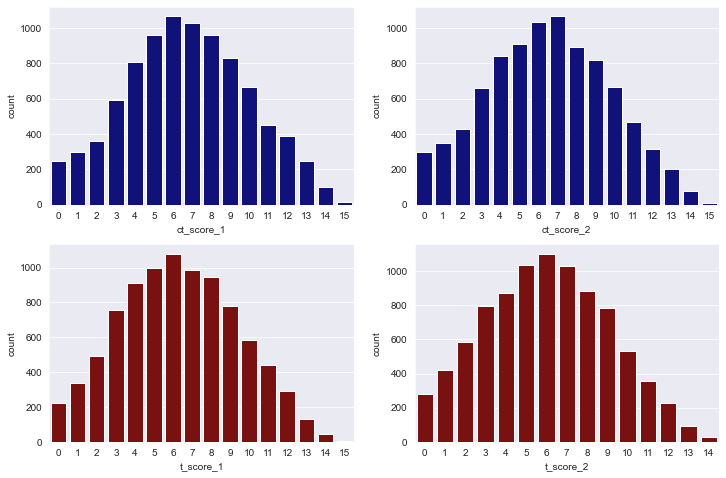

In [12]:
sns.set_style('darkgrid')
f, ax = plt.subplots(2,2, figsize=(12,8))
sns.countplot(x='ct_score_1', data=mirage_df, ax=ax[0,0], color='darkblue')
sns.countplot(x='ct_score_2', data=mirage_df, ax=ax[0,1], color='darkblue')
sns.countplot(x='t_score_1', data=mirage_df, ax=ax[1,0], color='darkred')
sns.countplot(x='t_score_2', data=mirage_df, ax=ax[1,1], color='darkred')

In [84]:
def map_score_plots(_map):
    df = results[results['_map'] == _map]
    f, ax = plt.subplots(2,2, figsize=(16,10))
    f.suptitle(f'{_map} Round Wins Based On Side', y=.93, fontsize=16)

    sns.countplot(x='ct_score_1', data=df, ax=ax[0,0], color='darkblue')
    ax[0,0].bar_label(ax[0,0].containers[0], fontsize=14)

    sns.countplot(x='ct_score_2', data=df, ax=ax[0,1], color='darkblue')
    ax[0,1].bar_label(ax[0,1].containers[0], fontsize=14)

    sns.countplot(x='t_score_1', data=df, ax=ax[1,0], color='darkred')
    ax[1,0].bar_label(ax[1,0].containers[0], fontsize=14)

    sns.countplot(x='t_score_2', data=df, ax=ax[1,1], color='darkred')
    ax[1,1].bar_label(ax[1,1].containers[0], fontsize=14)

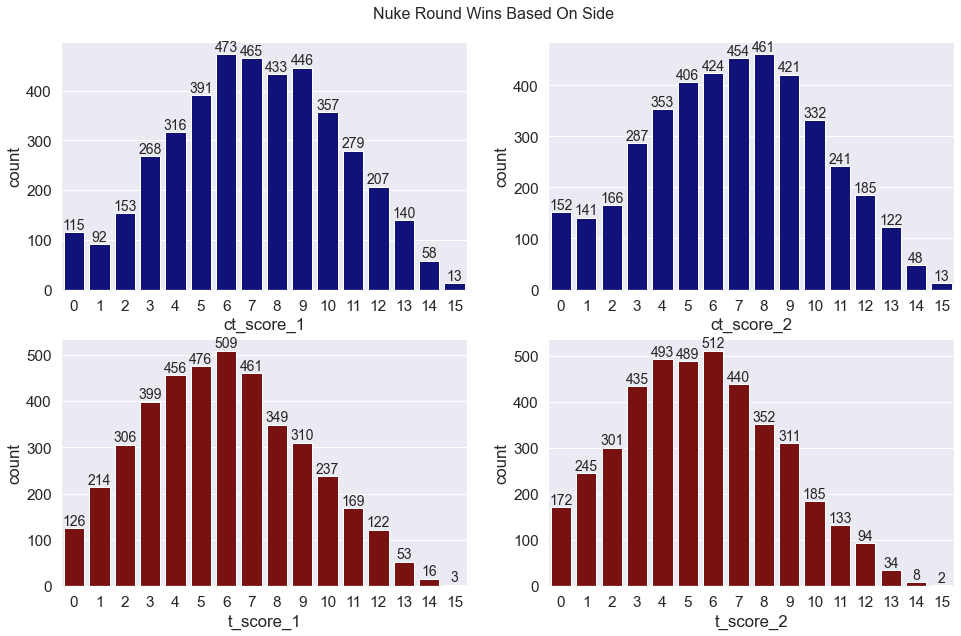

In [85]:
map_score_plots('Nuke')

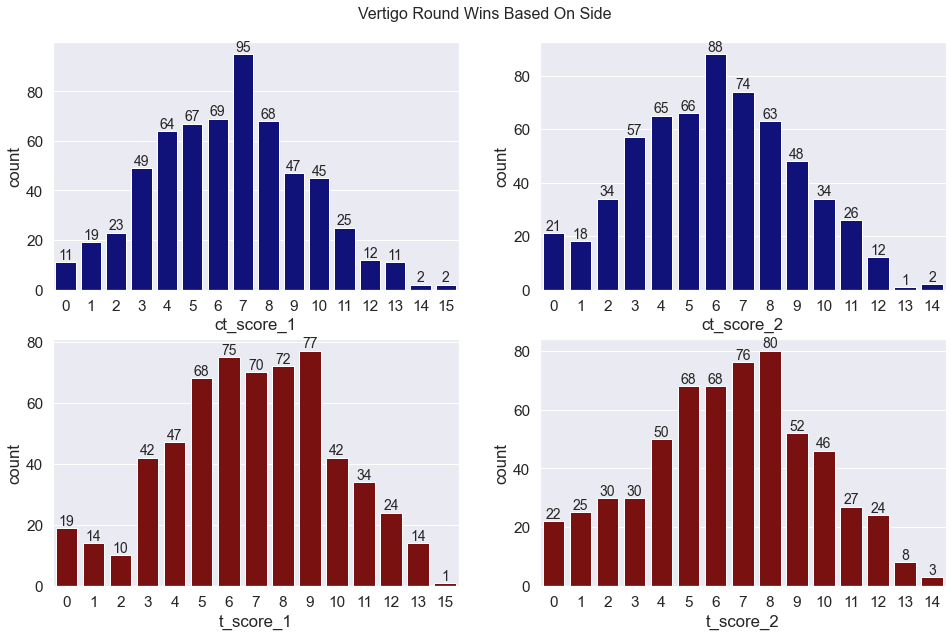

In [86]:
map_score_plots('Vertigo')

In [16]:
# 1 means Terrorists won the side and 0 means Counter-Terrorists won 
def side_won_1(df):
    if (df['ct_score_1'] - df['t_score_2']) < 0:
        return 1
    else:
        return 0
    
results['side_won_1'] = results.apply(side_won_1, axis=1)
results['side_won_1'].value_counts() 

0    25320
1    20432
Name: side_won_1, dtype: int64

In [17]:
def side_won_2(df):
    if (df['ct_score_2'] - df['t_score_1']) < 0:
        return 1
    else:
        return 0
    
results['side_won_2'] = results.apply(side_won_2, axis=1)
results['side_won_2'].value_counts() 

0    22883
1    22869
Name: side_won_2, dtype: int64

In [18]:
results.head()

,date,team_1,team_2,_map,score_1,score_2,map_winner,starting_ct,ct_score_1,t_score_2,t_score_1,ct_score_2,event_id,match_id,match_winner,side_won_1,side_won_2
0,737502,Recon 5,TeamOne,Dust2,0,16,2,2,0,1,0,15,5151,2340454,2,1,0
1,737502,Recon 5,TeamOne,Inferno,13,16,2,2,8,6,5,10,5151,2340454,2,0,0
2,737502,New England Whalers,Station7,Inferno,12,16,2,1,9,6,3,10,5243,2340461,2,0,0
3,737502,Rugratz,Bad News Bears,Inferno,7,16,2,2,0,8,7,8,5151,2340453,2,1,0
4,737502,Rugratz,Bad News Bears,Vertigo,8,16,2,2,4,5,4,11,5151,2340453,2,1,0


In [19]:
# ct v t side winrates
# Let's do the side winrates for Nuke
nuke_df = results[results['_map'] == 'Nuke']
t_pct = np.round(100 * ((nuke_df['side_won_1'].sum() + nuke_df['side_won_2'].sum())/(nuke_df.shape[0] * 2)), 2)
ct_pct = 100 - t_pct
pd.DataFrame([ct_pct, t_pct], index=['CT', 'T'], columns=['Side Win %'])

,Side Win %
CT,59.85
T,40.15


In [20]:
pct_data = []
maps = ['Mirage', 'Inferno', 'Train', 'Overpass', 'Nuke', 'Dust2', 'Cache', 'Cobblestone', 'Vertigo']
for m in maps:
    df = results[results['_map'] == m]
    t_pct = np.round(100 * ((df['side_won_1'].sum() + df['side_won_2'].sum())/(df.shape[0] * 2)), 2)
    ct_pct = 100 - t_pct
    pct_data.append(ct_pct)
    pct_data.append(t_pct)
    
outside = ['Mirage', 'Mirage', 'Inferno', 'Inferno', 'Train', 'Train', 'Overpass', 'Overpass', 'Nuke', 'Nuke', 'Dust2', 'Dust2', 'Cache', 'Cache', 'Cobblestone', 'Cobblestone', 'Vertigo', 'Vertigo']
inside = ['CT', 'T', 'CT', 'T', 'CT', 'T', 'CT', 'T', 'CT', 'T', 'CT', 'T', 'CT', 'T', 'CT', 'T', 'CT', 'T']
hier_index = list(zip(outside,inside))
hier_index = pd.MultiIndex.from_tuples(hier_index)

pd.DataFrame(pct_data, index=hier_index, columns=['Side Win %'])

Side Win %
Mirage      CT       53.85
            T        46.15
Inferno     CT       49.00
            T        51.00
Train       CT       58.22
            T        41.78
Overpass    CT       56.04
            T        43.96
Nuke        CT       59.85
            T        40.15
Dust2       CT       47.78
            T        52.22
Cache       CT       46.24
            T        53.76
Cobblestone CT       48.38
            T        51.62
Vertigo     CT       46.88
            T        53.12

From this table we can see most maps do have a CT or T advantage. The maps that have a great disparity between the win percentages are: Train, Nuke, and Overpass, all of which are CT sided. Looking at Vertigo, while the T side does have a higher win percentage than the CT side, the difference is not as large to conclude that the map has a T side advantage. This may be because of the fact that Vertigo is a much newer map and lacks the same amount of data that the other maps have.

Final note on this question: The side win percentages are calculated based on both sides played, this may have a flaw given that in CS:GO one half is always played in full while the other side often does not play out all 15 rounds. This is one thing to consider in future anaylsis, perhaps to account for this we can weight the side that is played in full higher than the other.  

=============================================================================

## Find out Astralis' win rate on each map

In [21]:
results[(results['team_1'] == 'Astralis') | (results['team_2'] == 'Astralis')].head()
# Astralis have played 872 maps between 2015-2020

,date,team_1,team_2,_map,score_1,score_2,map_winner,starting_ct,ct_score_1,t_score_2,t_score_1,ct_score_2,event_id,match_id,match_winner,side_won_1,side_won_2
47,737500,Astralis,NiP,Overpass,8,16,2,2,4,5,4,11,5226,2340065,2,1,0
49,737500,Astralis,NiP,Vertigo,6,16,2,1,3,12,3,4,5226,2340065,2,1,0
676,737484,Natus Vincere,Astralis,Nuke,16,5,1,1,13,2,3,3,4901,2339401,1,0,0
677,737484,Natus Vincere,Astralis,Dust2,16,5,1,2,2,4,14,1,4901,2339401,1,1,1
713,737482,Astralis,fnatic,Vertigo,16,8,1,2,7,2,9,6,4901,2339394,1,0,1


In [22]:
astralis_results = results[(results['team_1'] == 'Astralis') | (results['team_2'] == 'Astralis')]

In [23]:
astralis_results['_map'].value_counts()

Inferno        173
Overpass       153
Train          131
Mirage         129
Nuke           110
Dust2           99
Cache           54
Vertigo         14
Cobblestone      9
Name: _map, dtype: int64

In [24]:
def win_rate_per_map(team: str):
    assert (team in results['team_1'].unique() or team in results['team_2'].unique())
    team_df = results[(results['team_1'] == team) | (results['team_2'] == team)]
    
    win_count = {'Inferno': 0, 'Overpass': 0, 'Train': 0, 'Mirage': 0, 'Nuke': 0, 'Dust2': 0, 'Cache': 0,
            'Vertigo': 0, 'Cobblestone': 0}
    map_count = {'Inferno': 0, 'Overpass': 0, 'Train': 0, 'Mirage': 0, 'Nuke': 0, 'Dust2': 0, 'Cache': 0,
            'Vertigo': 0, 'Cobblestone': 0}
    maps_played = 0
    
    for index, row in team_df.iterrows():
        if row['team_1'] == team:
            team_df = 1
        else:
            team_df = 2
        current_map = row['_map']
        if row['map_winner'] == team_df:
            win_count[current_map] += 1
        maps_played += 1
        map_count[current_map] += 1
    
    map_winrate = {key: (100*np.round(value/map_count[key], 4)) for key, value in win_count.items()}
    
    return pd.DataFrame([map_winrate, win_count, map_count], index=['Win %', 'Win Count','Map Count']).transpose()

In [25]:
win_rate_per_map('Astralis')

,Win %,Win Count,Map Count
Inferno,75.14,130.0,173.0
Overpass,66.67,102.0,153.0
Train,65.65,86.0,131.0
Mirage,68.99,89.0,129.0
Nuke,75.45,83.0,110.0
Dust2,63.64,63.0,99.0
Cache,59.26,32.0,54.0
Vertigo,71.43,10.0,14.0
Cobblestone,11.11,1.0,9.0


# See if features need to be added/changed/removed in order to build a model to predict match winners 

Let's build a model that predicts map win based on the halftime score 

In [26]:
def halftime_1(df):
    if df['starting_ct'] == 1:
        return df['ct_score_1'] 
    else:
        return df['t_score_1']

def halftime_2(df):
    if df['starting_ct'] == 2:
        return df['ct_score_2'] 
    else:
        return df['t_score_2']
    
    
results['ht_score_1'] = results.apply(halftime_1, axis=1)
results['ht_score_2'] = results.apply(halftime_2, axis=1)

In [27]:
results.head()

,date,team_1,team_2,_map,score_1,score_2,map_winner,starting_ct,ct_score_1,t_score_2,t_score_1,ct_score_2,event_id,match_id,match_winner,side_won_1,side_won_2,ht_score_1,ht_score_2
0,737502,Recon 5,TeamOne,Dust2,0,16,2,2,0,1,0,15,5151,2340454,2,1,0,0,15
1,737502,Recon 5,TeamOne,Inferno,13,16,2,2,8,6,5,10,5151,2340454,2,0,0,5,10
2,737502,New England Whalers,Station7,Inferno,12,16,2,1,9,6,3,10,5243,2340461,2,0,0,9,6
3,737502,Rugratz,Bad News Bears,Inferno,7,16,2,2,0,8,7,8,5151,2340453,2,1,0,7,8
4,737502,Rugratz,Bad News Bears,Vertigo,8,16,2,2,4,5,4,11,5151,2340453,2,1,0,4,11


In [28]:
results.drop(['team_1', 'team_2', 'event_id', 'match_id'], axis=1, inplace=True)

In [29]:
results = results.astype({'map_winner': 'category', 'starting_ct': 'category', 'match_winner': 'category', 'side_won_1': 'category', 'side_won_2': 'category'})

In [30]:
results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45752 entries, 0 to 45772
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   date          45752 non-null  int64   
 1   _map          45752 non-null  object  
 2   score_1       45752 non-null  int64   
 3   score_2       45752 non-null  int64   
 4   map_winner    45752 non-null  category
 5   starting_ct   45752 non-null  category
 6   ct_score_1    45752 non-null  int64   
 7   t_score_2     45752 non-null  int64   
 8   t_score_1     45752 non-null  int64   
 9   ct_score_2    45752 non-null  int64   
 10  match_winner  45752 non-null  category
 11  side_won_1    45752 non-null  category
 12  side_won_2    45752 non-null  category
 13  ht_score_1    45752 non-null  int64   
 14  ht_score_2    45752 non-null  int64   
dtypes: category(5), int64(9), object(1)
memory usage: 4.1+ MB


In [31]:
results_dummy = pd.get_dummies(data=results, drop_first=True)
results_dummy.drop(['score_1', 'score_2', 'ct_score_1', 'ct_score_2', 't_score_1', 't_score_2', 'match_winner_2', 'side_won_1_1', 'side_won_2_1'], axis=1, inplace=True)

In [32]:
X = results_dummy.drop(['map_winner_2'], axis=1)
y = results_dummy['map_winner_2']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

## Logistic Regression


In [33]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [34]:
logreg_pred = logreg.predict(X_test)

In [35]:
print(confusion_matrix(y_test, logreg_pred))

[[7347    0]
 [6379    0]]


In [36]:
print(classification_report(y_test, logreg_pred))

              precision    recall  f1-score   support

           0       0.54      1.00      0.70      7347
           1       0.00      0.00      0.00      6379

    accuracy                           0.54     13726
   macro avg       0.27      0.50      0.35     13726
weighted avg       0.29      0.54      0.37     13726



In [37]:
print(accuracy_score(y_test, logreg_pred))

0.5352615474282384


Hyperparameter optimization for logreg

In [38]:
param_grid = {'C': [0.01, 0.1, 1, 10, 100], 'solver': ['newton-cg', 'lbfgs', 'liblinear']}

In [39]:
grid = GridSearchCV(LogisticRegression(), param_grid, refit=True, verbose=0)

In [40]:
grid.fit(X_train, y_train)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']})

In [41]:
grid.best_params_

{'C': 0.01, 'solver': 'newton-cg'}

In [42]:
grid.best_estimator_

LogisticRegression(C=0.01, solver='newton-cg')

In [43]:
grid_pred = grid.predict(X_test)

In [44]:
print(confusion_matrix(y_test, grid_pred))

[[5754 1593]
 [1524 4855]]


In [45]:
print(classification_report(y_test, grid_pred))

              precision    recall  f1-score   support

           0       0.79      0.78      0.79      7347
           1       0.75      0.76      0.76      6379

    accuracy                           0.77     13726
   macro avg       0.77      0.77      0.77     13726
weighted avg       0.77      0.77      0.77     13726



In [46]:
print(accuracy_score(y_test, grid_pred))

0.7729127203846714


## Random Forest

In [47]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [48]:
rfc_pred = rfc.predict(X_test)

In [49]:
print(confusion_matrix(y_test,rfc_pred))

[[5345 2002]
 [2084 4295]]


In [50]:
print(classification_report(y_test,rfc_pred))

              precision    recall  f1-score   support

           0       0.72      0.73      0.72      7347
           1       0.68      0.67      0.68      6379

    accuracy                           0.70     13726
   macro avg       0.70      0.70      0.70     13726
weighted avg       0.70      0.70      0.70     13726



In [51]:
print(accuracy_score(y_test, rfc_pred))

0.7023167710913595


In [52]:
param_grid = {'n_estimators': [10, 100, 1000], 'max_features': ['sqrt', 'log2'], 'max_features': [1, 2, 3, 4, 5, 6]}
rfc_grid = GridSearchCV(RandomForestClassifier(), param_grid, refit=True, verbose=3)

In [53]:
rfc_grid.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END ...max_features=1, n_estimators=10;, score=0.708 total time=   0.1s
[CV 2/5] END ...max_features=1, n_estimators=10;, score=0.710 total time=   0.1s
[CV 3/5] END ...max_features=1, n_estimators=10;, score=0.709 total time=   0.1s
[CV 4/5] END ...max_features=1, n_estimators=10;, score=0.705 total time=   0.1s
[CV 5/5] END ...max_features=1, n_estimators=10;, score=0.707 total time=   0.1s
[CV 1/5] END ..max_features=1, n_estimators=100;, score=0.703 total time=   2.0s
[CV 2/5] END ..max_features=1, n_estimators=100;, score=0.704 total time=   2.0s
[CV 3/5] END ..max_features=1, n_estimators=100;, score=0.697 total time=   2.0s
[CV 4/5] END ..max_features=1, n_estimators=100;, score=0.705 total time=   1.9s
[CV 5/5] END ..max_features=1, n_estimators=100;, score=0.703 total time=   1.9s
[CV 1/5] END .max_features=1, n_estimators=1000;, score=0.702 total time=  20.5s
[CV 2/5] END .max_features=1, n_estimators=1000;

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_features': [1, 2, 3, 4, 5, 6],
                         'n_estimators': [10, 100, 1000]},
             verbose=3)

In [54]:
rfc_grid.best_params_

{'max_features': 6, 'n_estimators': 10}

In [55]:
rfc_grid_pred = rfc_grid.predict(X_test)

In [56]:
print(confusion_matrix(y_test, rfc_grid_pred))

[[5493 1854]
 [2138 4241]]


In [57]:
print(classification_report(y_test, rfc_grid_pred))

              precision    recall  f1-score   support

           0       0.72      0.75      0.73      7347
           1       0.70      0.66      0.68      6379

    accuracy                           0.71     13726
   macro avg       0.71      0.71      0.71     13726
weighted avg       0.71      0.71      0.71     13726



In [58]:
print(accuracy_score(y_test, rfc_grid_pred))

0.7091650881538686


The logisitic regression model once optimized performed the best on the data. The simplest model will usually be the model that will perform the best. Sometimes, even if the more complicated model performed slightly better, it may be best to go with the simpler model because there is less variance with simpler models. 

# Try models with different set of features

In [59]:
results.head()

,date,_map,score_1,score_2,map_winner,starting_ct,ct_score_1,t_score_2,t_score_1,ct_score_2,match_winner,side_won_1,side_won_2,ht_score_1,ht_score_2
0,737502,Dust2,0,16,2,2,0,1,0,15,2,1,0,0,15
1,737502,Inferno,13,16,2,2,8,6,5,10,2,0,0,5,10
2,737502,Inferno,12,16,2,1,9,6,3,10,2,0,0,9,6
3,737502,Inferno,7,16,2,2,0,8,7,8,2,1,0,7,8
4,737502,Vertigo,8,16,2,2,4,5,4,11,2,1,0,4,11


In [60]:
results_dummy.head()

,date,ht_score_1,ht_score_2,_map_Cobblestone,_map_Dust2,_map_Inferno,_map_Mirage,_map_Nuke,_map_Overpass,_map_Train,_map_Vertigo,map_winner_2,starting_ct_2
0,737502,0,15,0,1,0,0,0,0,0,0,1,1
1,737502,5,10,0,0,1,0,0,0,0,0,1,1
2,737502,9,6,0,0,1,0,0,0,0,0,1,0
3,737502,7,8,0,0,1,0,0,0,0,0,1,1
4,737502,4,11,0,0,0,0,0,0,0,1,1,1


In [61]:
X = results_dummy[['ht_score_1', 'ht_score_2', '_map_Cobblestone', 'starting_ct_2']]
y = results_dummy['map_winner_2']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [62]:
logreg_2 = LogisticRegression(C=0.01, solver='newton-cg')
logreg_2.fit(X_train, y_train)

LogisticRegression(C=0.01, solver='newton-cg')

In [63]:
pred_2 = logreg_2.predict(X_test)

In [64]:
print(confusion_matrix(y_test, pred_2))

[[5754 1593]
 [1524 4855]]


In [65]:
print(classification_report(y_test, pred_2))

              precision    recall  f1-score   support

           0       0.79      0.78      0.79      7347
           1       0.75      0.76      0.76      6379

    accuracy                           0.77     13726
   macro avg       0.77      0.77      0.77     13726
weighted avg       0.77      0.77      0.77     13726



In [66]:
print(accuracy_score(y_test, pred_2))

0.7729127203846714
